## Test AST - Rémi Ançay - 2025

This notebook allows to test an AST (Audio Spectrogram Transformer) model on a dataset of audio files.

Configure your dataset path and the model path below, then run the cells to test the model.

In [1]:
# Imports
from datasets import Dataset, DatasetDict, Audio
from transformers import ASTFeatureExtractor, ASTForAudioClassification
import os
import numpy as np
import torch
from sklearn.metrics import classification_report

c:\Users\remia\anaconda3\envs\tbLoup\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
path_to_dataset = "Datasets/BarkopediaIndividualDataset/"

model_path = "./OutputClassifier/ASTBarkopediaIndividual"

In [3]:
# Load the model
model = ASTForAudioClassification.from_pretrained(model_path)
feature_extractor = ASTFeatureExtractor.from_pretrained(model_path)

In [4]:
# Load the test dataset
def load_test_dataset(root_dir):
    data = {"file": [], "label": []}
    split_dir = os.path.join(root_dir, "test")
    for label_name in os.listdir(split_dir):
        label_dir = os.path.join(split_dir, label_name)
        if not os.path.isdir(label_dir):
            continue
        for filename in os.listdir(label_dir):
            if filename.endswith(".wav"):
                data["file"].append(os.path.join(label_dir, filename))
                data["label"].append(label_name)

    raw_dataset = Dataset.from_dict(data)

    raw_dataset = raw_dataset.cast_column("file", Audio(sampling_rate=16000))
    raw_dataset = raw_dataset.class_encode_column("label")

    return DatasetDict({
        "test": raw_dataset
    })

In [5]:
test_dataset = load_test_dataset(path_to_dataset)

Casting to class labels: 100%|██████████| 50/50 [00:00<00:00, 19546.57 examples/s]


In [6]:
# Preprocess the dataset
def preprocess(example):
    audio = example["file"]
    inputs = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"])
    example["input_values"] = inputs["input_values"][0]
    return example

test_dataset = test_dataset.map(preprocess, remove_columns=["file"])

Map: 100%|██████████| 50/50 [00:04<00:00, 11.10 examples/s]


In [7]:
# Evaluate the model
model.eval()
all_preds, all_labels = [], []

for sample in test_dataset["test"]:
    inputs = torch.tensor(sample["input_values"]).unsqueeze(0)
    with torch.no_grad():
        outputs = model(inputs)
    pred = torch.argmax(outputs.logits, dim=-1).item()
    all_preds.append(pred)
    all_labels.append(sample["label"])

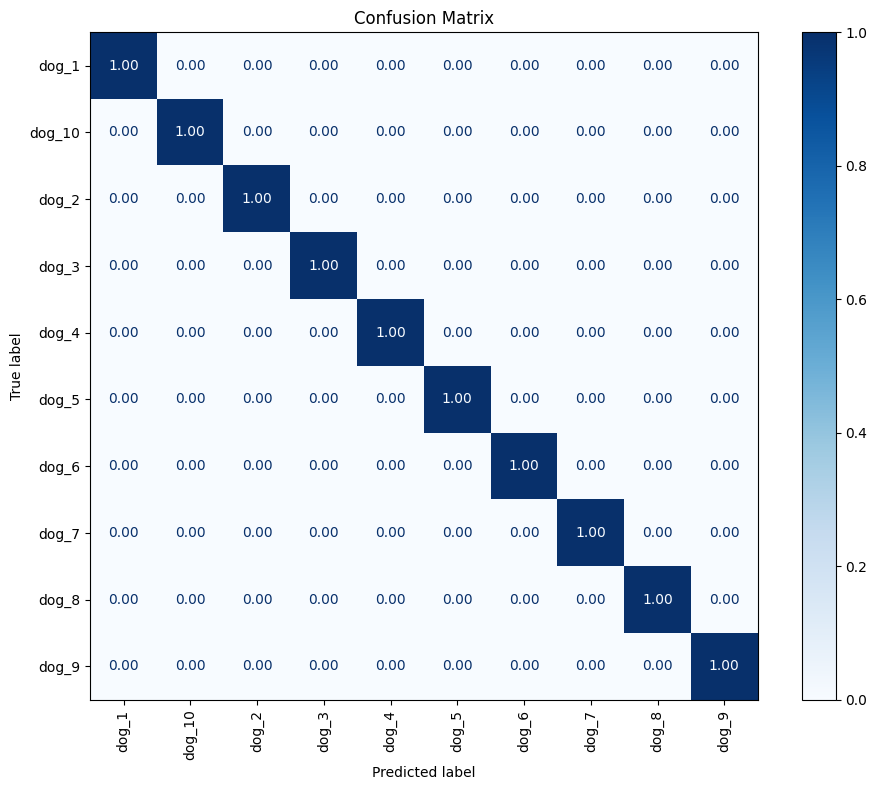

              precision    recall  f1-score   support

       dog_1       1.00      1.00      1.00         5
      dog_10       1.00      1.00      1.00         5
       dog_2       1.00      1.00      1.00         4
       dog_3       1.00      1.00      1.00         4
       dog_4       1.00      1.00      1.00         4
       dog_5       1.00      1.00      1.00         5
       dog_6       1.00      1.00      1.00         4
       dog_7       1.00      1.00      1.00        10
       dog_8       1.00      1.00      1.00         4
       dog_9       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Show confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')
label_names = test_dataset["test"].features["label"].names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=90, values_format=".2f")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Show classification report
id2label = test_dataset["test"].features["label"].int2str
label_names = test_dataset["test"].features["label"].names

print(classification_report(all_labels, all_preds, target_names=label_names))

